In [ ]:
import os
current_directory = os.getcwd()
import sys; sys.path.insert(0, current_directory)

In [2]:
import mne
import pickle as pkl
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

#### =========================================================================
#### Section 1: Data Loading Setup
#### This section defines a helper function to load data from pickle files
#### and sets up the directory paths for loading the pre-computed results
#### (from the previous script) that are ready for plotting.
#### =========================================================================

In [3]:
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pkl.load(f)
    return data

In [4]:
# Define the folder path for loading EMD results
folder_load = "Results"
folder_pathload = os.path.join(os.getcwd(), folder_load)

# Define the folder path for evaluated inverse solutions (not used in this script but kept for context)
folder_name = "Evaluated_Data"
folder_path = os.path.join(os.getcwd(), folder_name)

#### =========================================================================
#### Section 2: Main Plotting Loop
#### This is the primary execution block of the script. It systematically
#### iterates through different simulation parameters (SNR, spatial smoothness,
#### patch ranks, and source correlation). For each combination, it loads the
#### corresponding EMD results, calculates summary statistics, and generates
#### a comparative bar plot.
#### =========================================================================

0.3
0.5
0.9


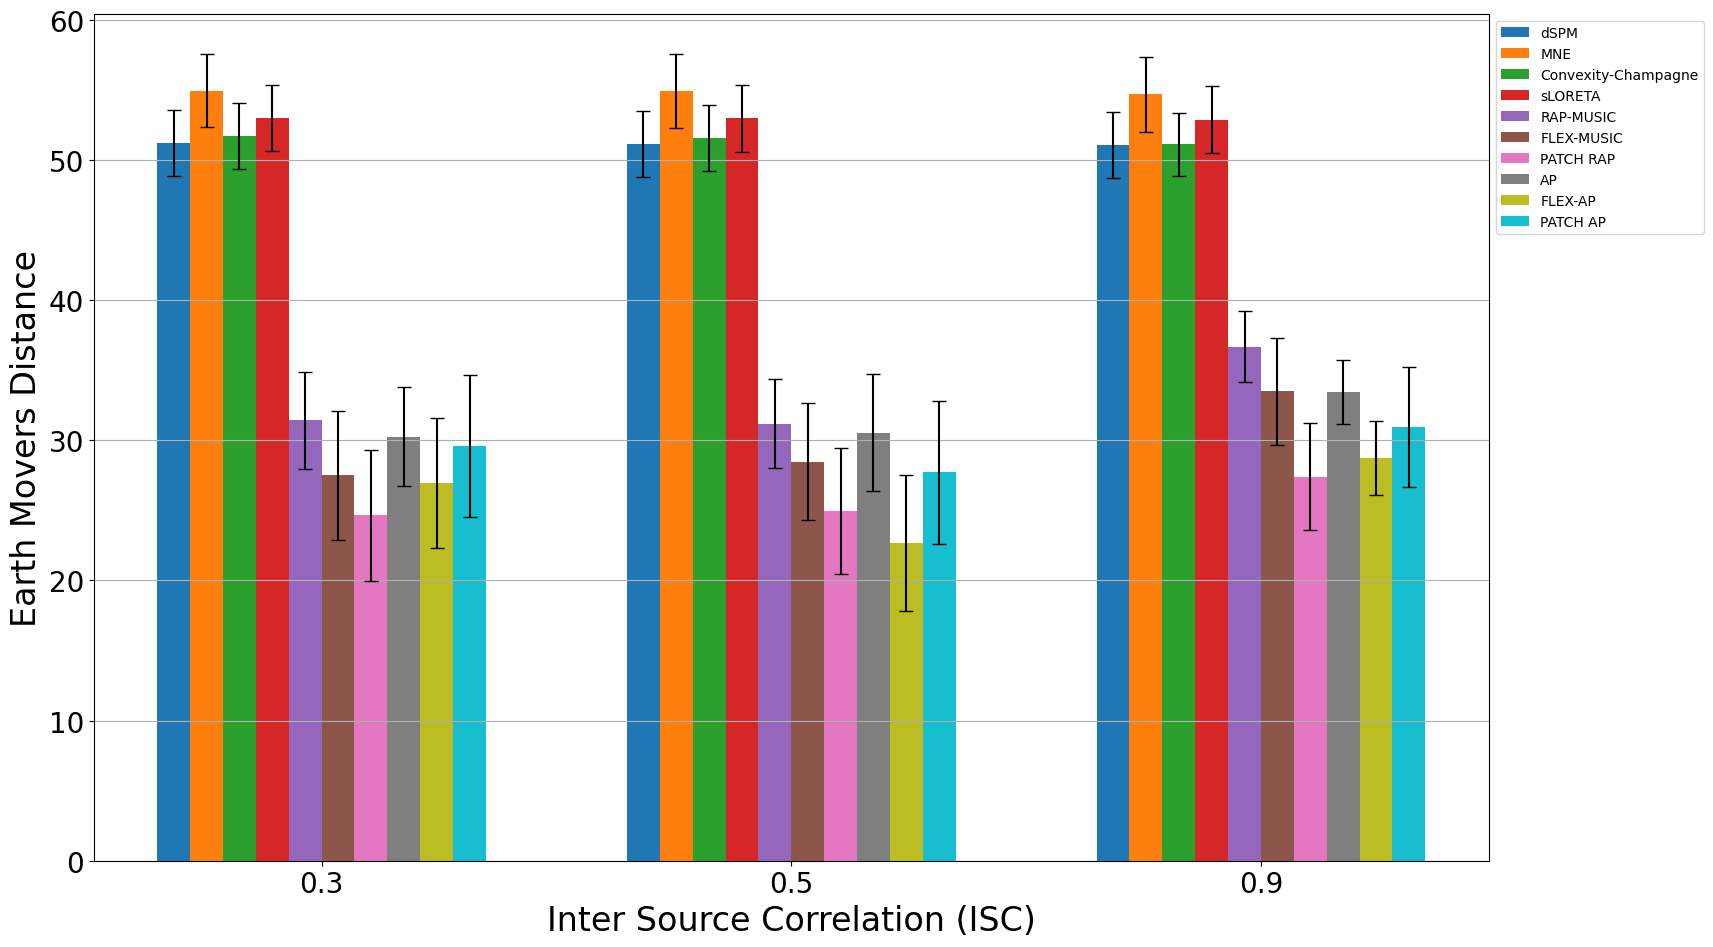

c:\Users\Admin\OneDrive\Desktop\B.Tech Project\Patch-AP-Solution\Python Scripts\Manuscript_Figures/Effect_of_ISC\LEN_snr_db_-5_smooth_0_patchranks_[1, 2]_inv_name_coarse-80.png
Elapsed time for corr_coeff=0.9, Smoothness_order=0, Patchranks=[1, 2], snr_db=-5: 2.2026185989379883 seconds
0.3
0.5
0.9


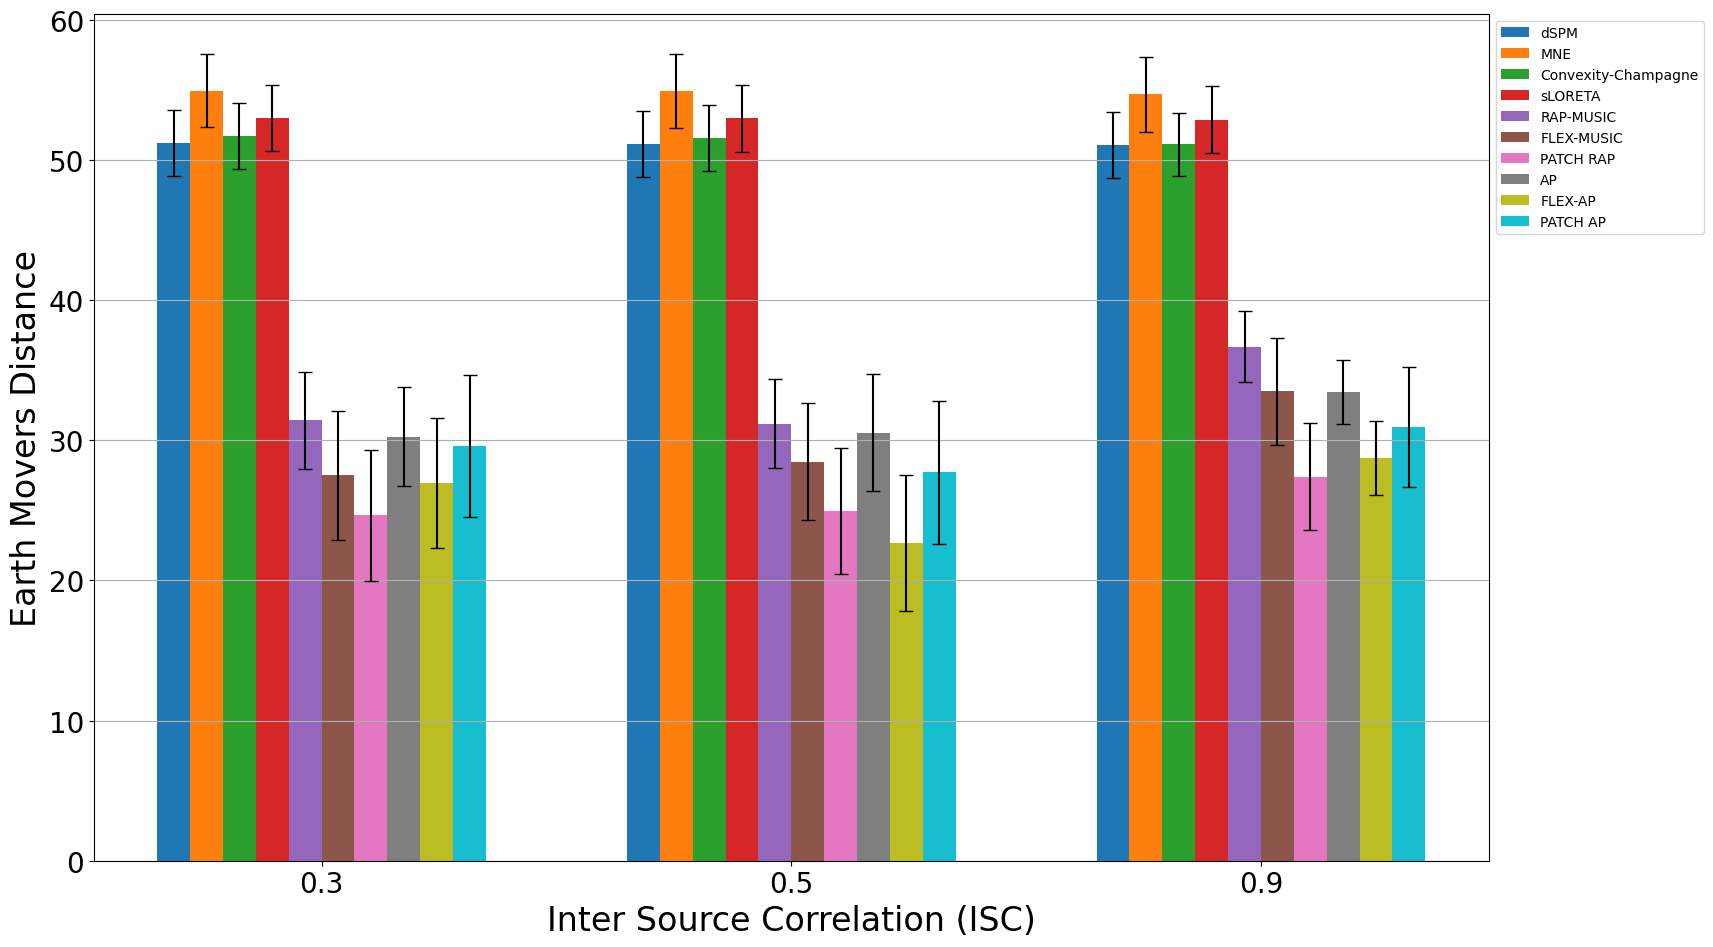

c:\Users\Admin\OneDrive\Desktop\B.Tech Project\Patch-AP-Solution\Python Scripts\Manuscript_Figures/Effect_of_ISC\LEN_snr_db_-5_smooth_2_patchranks_[1, 2]_inv_name_coarse-80.png
Elapsed time for corr_coeff=0.9, Smoothness_order=2, Patchranks=[1, 2], snr_db=-5: 2.557999849319458 seconds
0.3
0.5
0.9


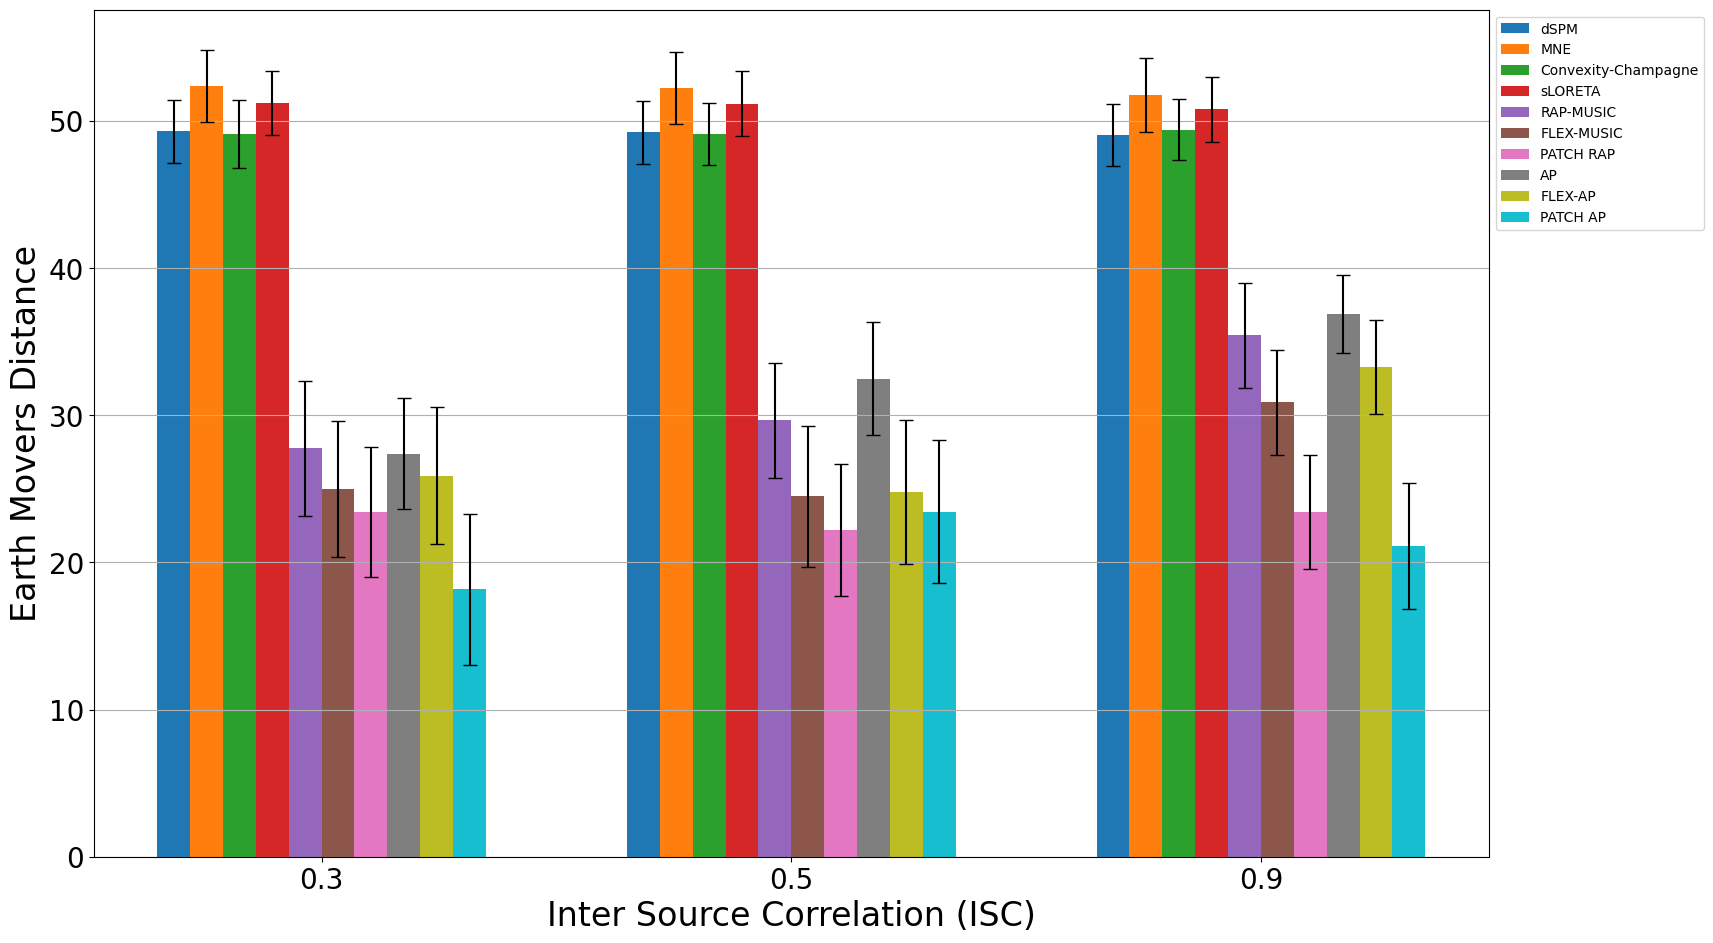

c:\Users\Admin\OneDrive\Desktop\B.Tech Project\Patch-AP-Solution\Python Scripts\Manuscript_Figures/Effect_of_ISC\LEN_snr_db_0_smooth_0_patchranks_[1, 2]_inv_name_coarse-80.png
Elapsed time for corr_coeff=0.9, Smoothness_order=0, Patchranks=[1, 2], snr_db=0: 2.128037929534912 seconds
0.3
0.5
0.9


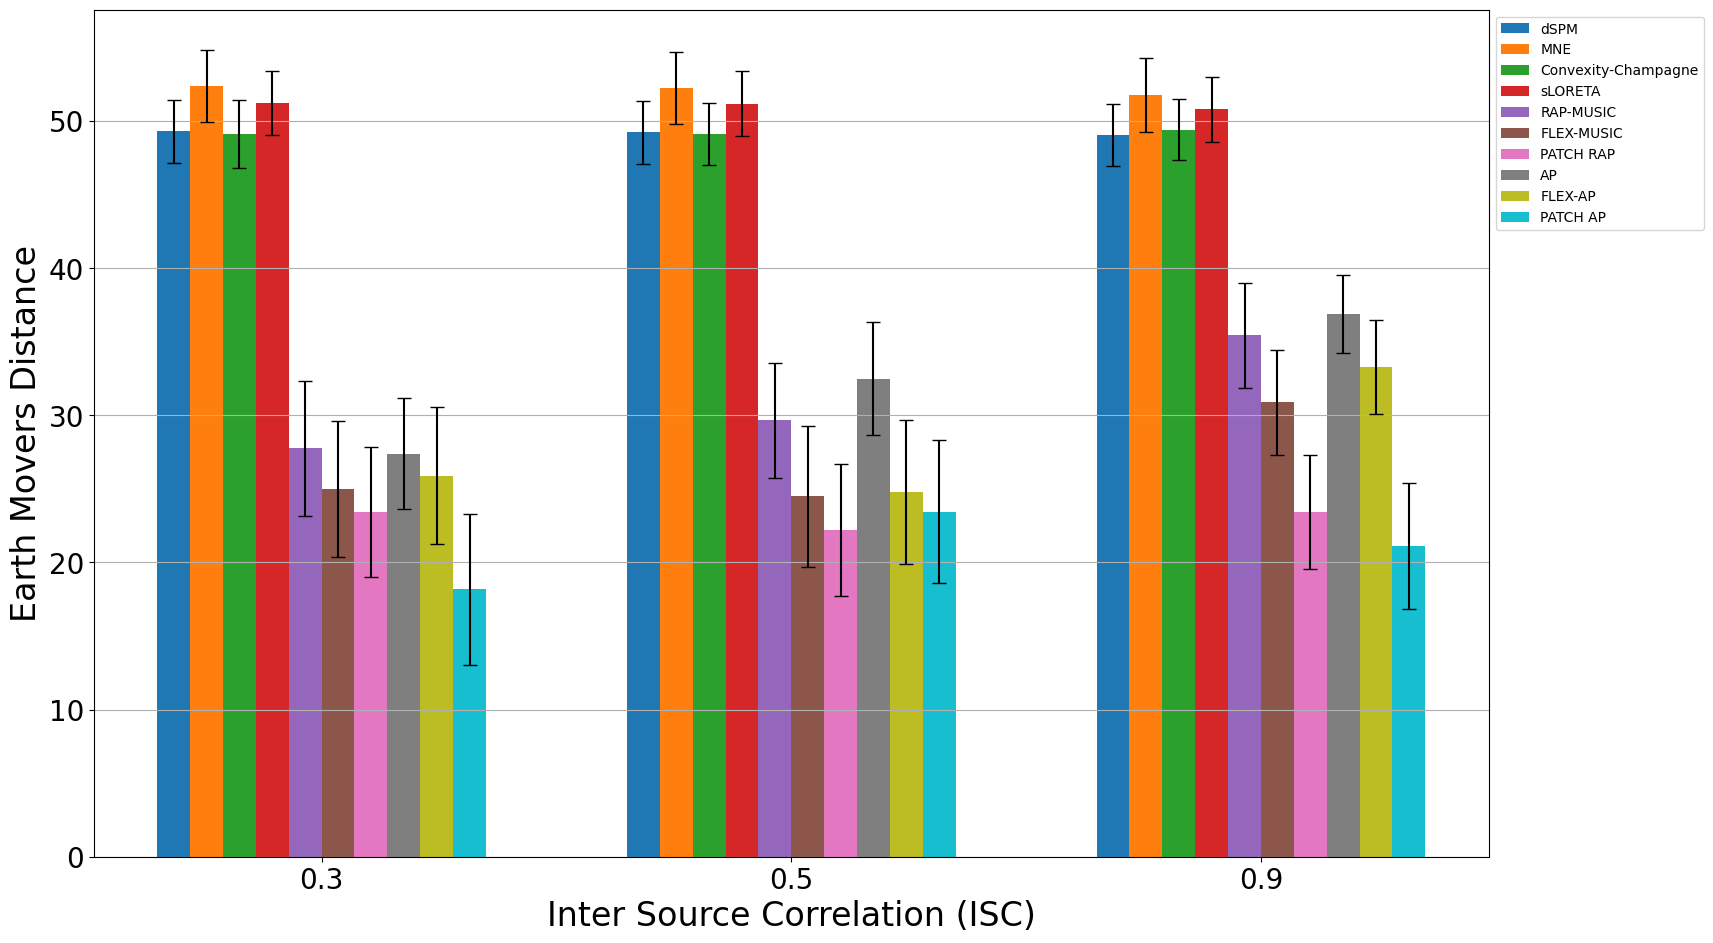

c:\Users\Admin\OneDrive\Desktop\B.Tech Project\Patch-AP-Solution\Python Scripts\Manuscript_Figures/Effect_of_ISC\LEN_snr_db_0_smooth_2_patchranks_[1, 2]_inv_name_coarse-80.png
Elapsed time for corr_coeff=0.9, Smoothness_order=2, Patchranks=[1, 2], snr_db=0: 1.44600248336792 seconds


In [5]:
batch_size = 10 # number of monte-carlo repetitions
inv_name = "coarse-80"
Patchranks_Full = [[1,2]]
for snr_db in range(-5,5,5):
    for Smoothness_order in range(0,4,2):
        for Patchranks in Patchranks_Full:
            corr_coeffss = []
            # Define lists to store statistics for each correlation value for the current plot
            all_medians_values = []
            all_std_devs_values = []
            for corr_coeff in [0.3,0.5,0.9]:
                start_time = time.time()
                # Construct filename and load the pre-calculated EMD results
                filename = f"EMD_Len_{inv_name}_Data_corr_{corr_coeff}_smooth_{Smoothness_order}_patchranks_{Patchranks}_snr_{snr_db}.pkl"
                file_path = os.path.join(folder_pathload, filename)
                EMD_results = load_data(file_path)

                # =====================================================
                # Subsection 2.1: Calculate Summary Statistics
                # This block processes the loaded EMD results. It calculates
                # the median and the standard error of the mean for each
                # source localization method, which will be used for the
                # bar heights and error bars in the plot.
                # =====================================================
                EMD_medians = {key: np.median(values) for key, values in EMD_results.items()}
                EMD_stderr = {key: np.std(values) / np.sqrt(len(values)) for key, values in EMD_results.items()}

                # Extract method names and their corresponding statistics
                method_names = list(EMD_medians.keys())
                medians_values = list(EMD_medians.values())
                std_devs_values = list( EMD_stderr.values())

                # Standardize method names for consistency
                for im,aa in enumerate(method_names):
                    if method_names[im] == "Patch AP":
                        method_names[im] = "PATCH AP"
                    elif method_names[im] == "Patch RAP":
                        method_names[im] = "PATCH RAP"

                # =====================================================
                # Subsection 2.2: Reorder Data for Consistent Plotting
                # To ensure the bars in the plot always appear in the same
                # order, this block reorders the methods and their statistics
                # according to a predefined list (`desired_order`).
                # =====================================================
                desired_order = ['dSPM', 'MNE', 'Convexity-Champagne','sLORETA','RAP-MUSIC','FLEX-MUSIC','PATCH RAP','AP','FLEX-AP',
                                 'PATCH AP']
                reordered_method_names, reordered_medians_values,reordered_std_devs_values = [],[],[]
                for method in desired_order:
                    if method in method_names:
                        index = method_names.index(method)
                        reordered_method_names.append(method)
                        reordered_medians_values.append(medians_values[index])
                        reordered_std_devs_values.append(std_devs_values[index])
                method_names = reordered_method_names
                medians_values = reordered_medians_values
                std_devs_values = reordered_std_devs_values

                # Append the ordered statistics for the current correlation value to the main lists
                all_medians_values.append(medians_values)
                all_std_devs_values.append(std_devs_values)
                corr_coeffss.append(corr_coeff)

            # =========================================================
            # Section 3: Generate and Save the Plot
            # This section uses Matplotlib to create a detailed bar chart
            # comparing the performance (median EMD) of all localization
            # methods across different inter-source correlation values.
            # The final plot is then saved as a high-resolution image.
            # =========================================================
            # Set plot properties
            bar_width = 0.35
            fwd_name = inv_name

            # Initialize the figure and axes
            fig, ax = plt.subplots(figsize=(18, 11))

            # Loop through each correlation level and plot a group of bars
            index = 0
            for ss, ssnr in enumerate(corr_coeffss):
                print(ssnr)
                medians_values = [vals for vals in all_medians_values[ss]]
                std_devs_values = [stds for stds in all_std_devs_values[ss]]

                # Plot one bar for each method within the group
                for ii, method_name in enumerate(method_names):
                    if ss == 0:
                        # Add a label only for the first group to create the legend
                        ax.bar(index + ii * bar_width, medians_values[ii], bar_width, yerr=std_devs_values[ii], capsize=5, label=method_name)
                    else:
                        ax.bar(index + ii * bar_width, medians_values[ii], bar_width, yerr=std_devs_values[ii], capsize=5)
                index = index+5 # Add spacing between groups of bars

            # Configure plot labels, title, and ticks for readability
            ax.set_xlabel('Inter Source Correlation (ISC)', fontsize=24)
            ax.set_ylabel('Earth Movers Distance', fontsize=24)
            # (Title logic is commented out but can be enabled for more descriptive titles)

            # Set the x-axis tick positions and labels to correspond to the correlation groups
            ax.set_xticks(np.arange(len(corr_coeffss)) * 5 + (bar_width*len(method_names))/2 - bar_width/2) # Adjusted for the new index
            ax.set_xticklabels(corr_coeffss)

            # Customize legend and tick font sizes
            ax.legend(fontsize=20)
            ax.yaxis.grid(True)
            ax.tick_params(axis='both', which='major', labelsize=20)

            # Move the legend outside the main plot area
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

            plt.show()

            # Create the save directory and save the figure
            folder_save = "Manuscript_Figures/Effect_of_ISC"
            folder_save = os.path.join(os.getcwd(), folder_save)
            os.makedirs(folder_save, exist_ok=True) # Ensure directory exists

            filename = f"LEN_snr_db_{snr_db}_smooth_{Smoothness_order}_patchranks_{Patchranks}_inv_name_{inv_name}.png"
            figure_filename = os.path.join(folder_save, filename)
            print(figure_filename)
            fig.savefig(figure_filename, dpi=300, bbox_inches='tight', format='png')


            end_time = time.time()  # Record end time
            elapsed_time = end_time - start_time
            print(f"Elapsed time for corr_coeff={corr_coeff}, Smoothness_order={Smoothness_order}, Patchranks={Patchranks}, snr_db={snr_db}: {elapsed_time} seconds")

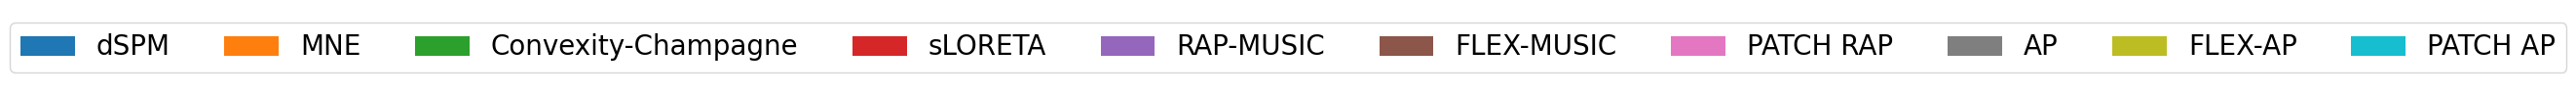

In [6]:
fig_legend, ax_legend = plt.subplots(figsize=(8, 1))  # Adjust the size as needed
handles, labels = ax.get_legend_handles_labels()
fig_legend.legend(handles, labels, loc='center', ncol=len(method_names), fontsize=20)

ax_legend.axis('off')  # Hide axes


plt.show()